In [1]:
from sentence_transformers import SentenceTransformer

pretrained_model = SentenceTransformer("sentence-transformers/distiluse-base-multilingual-cased-v1", device='cuda')
pretrained_model.to('cuda')
print(pretrained_model.device)
pretrained_model

cuda:0


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [2]:
from sentence_transformers import SentenceTransformer, models
from torch import nn

word_embedding_model = models.Transformer("sentence-transformers/distiluse-base-multilingual-cased-v1", max_seq_length=512)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
dense_model = models.Dense(in_features=pooling_model.get_sentence_embedding_dimension(), out_features=256, activation_function=nn.Tanh())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model, dense_model], device='cuda')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [3]:
import pandas as pd

dataset = pd.read_parquet("../dataset/train_math_exercice.parquet")
dataset

,problem,level,type,solution,id,source,category
0,Find the positive base $b$ in which the equati...,Level 4,Number Theory,When we rewrite the above equation with the ba...,number_theory_1004,test,4
1,There are eight boys and six girls who are mem...,Level 3,Counting & Probability,"First, we consider how many ways there are to ...",counting_and_probability_682,test,1
2,What is the domain of the function $g(x) = \fr...,Level 1,Intermediate Algebra,The formula for $g(x)$ has a defined value unl...,intermediate_algebra_1317,train,3
3,"A standard deck of 52 cards has 13 ranks (Ace,...",Level 3,Prealgebra,There are $3 \times 4 = 12$ face cards and 52 ...,prealgebra_1079,test,5
4,"The two endpoints of a segment are at $(1,4)$ ...",Level 1,Algebra,The midpoint of the segment is at $\left(\frac...,algebra_1025,test,0
...,...,...,...,...,...,...,...
9995,Given that 0.5 liters is approximately 1.05 pi...,Level 3,Prealgebra,"If half a liter is 1.05 pints, then a whole li...",prealgebra_532,train,5
9996,"In the figure shown, $AC=13$ and $DC=2$ units....",Level 4,Geometry,"Since $AC=AD+DC=13$ and $DC=2$, $AD=11$. We al...",geometry_953,test,2
9997,There are eight furlongs in a mile. There are ...,Level 4,Prealgebra,We have \[\n14\text{ days} = 1 \text{ fortnig...,prealgebra_1260,test,5
9998,"If a rectangular prism has a length of $l$, a ...",Level 2,Algebra,We are given that $$\sqrt{l^2 + w^2 + h^2} = \...,algebra_676,train,0


In [4]:
dataset["problem"]

0       Find the positive base $b$ in which the equati...
1       There are eight boys and six girls who are mem...
2       What is the domain of the function $g(x) = \fr...
3       A standard deck of 52 cards has 13 ranks (Ace,...
4       The two endpoints of a segment are at $(1,4)$ ...
                              ...                        
9995    Given that 0.5 liters is approximately 1.05 pi...
9996    In the figure shown, $AC=13$ and $DC=2$ units....
9997    There are eight furlongs in a mile. There are ...
9998    If a rectangular prism has a length of $l$, a ...
9999    What is the largest possible median for the fi...
Name: problem, Length: 10000, dtype: object

In [5]:
BATCH_SIZE = 32

dataset["sentence_embedding"] = pd.Series(
        pretrained_model.encode(dataset["problem"], batch_size=BATCH_SIZE, show_progress_bar=True).tolist()
    )

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [6]:
import numpy as np
from scipy.spatial.distance import cosine

def cosine_similarity(vec_a, vec_b) -> float:
        return 1 - cosine(
            np.array(vec_a).reshape(1, -1)[0],
            np.array(vec_b).reshape(1, -1)[0],
        )


In [7]:
from IPython.display import display, Latex

identical_category_scores = []
different_category_scores = []

for i, sample in dataset.iterrows():
    #print(sample['type'])
    #display(Latex(sample["problem"]))
    cat = sample['category']
    pos_example = dataset.loc[dataset['category']==cat].sample(n=1).iloc[0]
    identical_category_scores.append(cosine_similarity(sample["sentence_embedding"], pos_example["sentence_embedding"]))
    #print(pos_example["type"])
    #display(Latex(pos_example["problem"]))
    neg_example = dataset.loc[dataset['category']!=cat].sample(n=1).iloc[0]
    different_category_scores.append(cosine_similarity(sample["sentence_embedding"], neg_example["sentence_embedding"]))
    #print(neg_example["type"])
    #display(Latex(neg_example["problem"]))
    

Jensen-Shannon distance:  0.2100253901537971
Wasserstein distance:  0.070116880837928


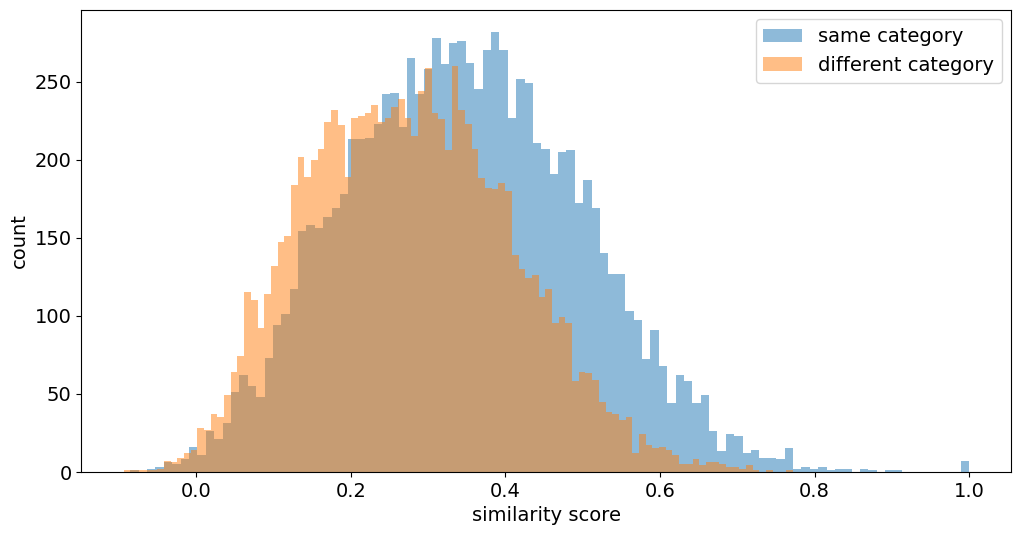

In [8]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import wasserstein_distance


print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores, 0.001, None), np.clip(different_category_scores, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores, different_category_scores))

plt.figure(figsize=(12, 6))
plt.hist(np.array(identical_category_scores), alpha=0.5, bins=100, label="same category")
plt.hist(np.array(different_category_scores), alpha=0.5, bins=100, label="different category")
plt.ylabel("count", fontsize=14)
plt.xlabel("similarity score", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14)
#plt.savefig("similarity_score_before_training_trainset.png", dpi=600, bbox_inches="tight")
plt.show()

In [9]:
print("Jensen-Shannon distance: ", distance.jensenshannon(np.clip(identical_category_scores, 0.001, None), np.clip(different_category_scores, 0.001, None)))
print("Wasserstein distance: ", wasserstein_distance(identical_category_scores, different_category_scores))

Jensen-Shannon distance:  0.2100253901537971
Wasserstein distance:  0.070116880837928
